<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/models/main-concat-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import numpy as np
from torchvision import io
from torchvision import transforms as T
from PIL import Image
import pickle
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset, random_split
import gc
from typing import Tuple
from torch.nn import functional as F
from collections import OrderedDict
import os
import sys

'''
IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    from pathlib import Path

    # Set up path for custom importer modules
    # Data Loader
    importer_module = root_dir + '/dataloader/'
    print(importer_module)
    sys.path.insert(0, importer_module)
    from loader import Ai4MarsImporter, Ai4MarsProcessor, Ai4MarsData

    # Loss

    loss_module = root_dir + '/trainer/loss/'
    sys.path.insert(0, loss_module)
    import loss

    # Trainer
    trainer_module = root_dir + '/trainer/'
    sys.path.insert(0, trainer_module)
    from trainer import Ai4MarsTrainer

    # Insert here your local path to the dataset (temporary)
    data_path = input("Path to Dataset: ") #'/home/leeoos/Desktop/'

else: # IN_COLAB

    from google.colab import drive
    drive.mount('/content/drive')

    # On Colab the path to the module ti fixed once you have
    # corretly set up the project with gitsetup.ipynb

    # Import Loader
    fixed_path_loader = '/content/drive/MyDrive/Github/visiope/dataloader/'
    sys.path.insert(0, fixed_path_loader)
    from loader import Ai4MarsImporter, Ai4MarsProcessor, Ai4MarsData

    # Import Trainer
    fixed_path_trainer = '/content/drive/MyDrive/Github/visiope/trainer/'
    sys.path.insert(0,fixed_path_trainer )
    from trainer import Ai4MarsTrainer

    # Import Loss
    fixed_path_loss = '/content/drive/MyDrive/Github/visiope/trainer/loss/'
    sys.path.insert(0, fixed_path_loss)
    import loss

    !git clone https://github.com/sithu31296/semantic-segmentation
    %pip install -U gdown
    %pip install -e .
    %pip install einops
    import gdown
    from pathlib import Path

    ckpt = Path('./checkpoints/pretrained/segformer')
    ckpt.mkdir(exist_ok=True, parents=True)

    url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
    output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

    gdown.download(url, output, quiet=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%cd semantic-segmentation
#/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/dataloader/
'''

'\nIN_COLAB = \'google.colab\' in sys.modules\n\nif not IN_COLAB:\n    from git import Repo\n\n    # Initialize the Git repository object\n    repo = Repo(".", search_parent_directories=True)\n\n    # Get the root directory of the Git project\n    root_dir = repo.git.rev_parse("--show-toplevel")\n\n    from pathlib import Path\n\n    # Set up path for custom importer modules\n    # Data Loader\n    importer_module = root_dir + \'/dataloader/\'\n    print(importer_module)\n    sys.path.insert(0, importer_module)\n    from loader import Ai4MarsImporter, Ai4MarsProcessor, Ai4MarsData\n\n    # Loss\n\n    loss_module = root_dir + \'/trainer/loss/\'\n    sys.path.insert(0, loss_module)\n    import loss\n\n    # Trainer\n    trainer_module = root_dir + \'/trainer/\'\n    sys.path.insert(0, trainer_module)\n    from trainer import Ai4MarsTrainer\n\n    # Insert here your local path to the dataset (temporary)\n    data_path = input("Path to Dataset: ") #\'/home/leeoos/Desktop/\'\n\nelse: # IN_

In [26]:
# Custom Imports
IN_COLAB = 'google.colab' in sys.modules
LOCAL = not IN_COLAB

if IN_COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/

    # Add custom modules to path
    custom_modules_path = '/content/visiope/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from IPython.display import display, HTML
    display(HTML("<style>.container { width:80% !important; }</style>"))

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)

else:
    raise Exception("Unknown Environment")


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


fatal: destination path '/content/visiope' already exists and is not an empty directory.


In [4]:
test = False
if test:
    class Generator(nn.Module):
        def __init__(self, nc):
            self.nc = nc
            super(Generator, self).__init__()


        def forward(self, embeds):
            ngf = 64
            nz = [[None] *6]*4

            j = 0
            for embed in embeds:
                nz[j][0] = embed.size()[1]
                for i in range(1,6):
                    if i < 4:
                        nz[j][i] = nz[i-1]//2
                    else:
                        nz[j][i] = nz[i-1]//4
                j = j+1
                print(nz)
            self.main = nn.Sequential(
                #reduction of dimensionality To Be Changed in conv... maybe
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz[6], ngf * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # state size. ``(ngf*8) x 4 x 4``
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # state size. ``(ngf*4) x 8 x 8``
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # state size. ``(ngf*2) x 16 x 16``
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # state size. ``(ngf) x 32 x 32``
                nn.ConvTranspose2d( ngf, self.nc, 4, 2, 1, bias=False),
                nn.Tanh()
                # state size. ``(nc) x 64 x 64``
            )

            return self.main(embed)

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        ngf = 64
        nc = 1
        print(nz)
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Python program to join tensors in PyTorch
# import necessary library
import torch

# create tensors

T1 = torch.zeros((2,2))
T2 = torch.Tensor([[1,2,3,4],[0,3,4,1]])
T3 = torch.Tensor([[4,3,2,5,6,5], [0,3,4,1,6,8]])

print(T1)

# join (concatenate) above tensors using torch.cat()
T = torch.cat((T1,T2,T3), dim=1)
# print final tensor after concatenation
print("T:",T)

tensor([[0., 0.],
        [0., 0.]])
T: tensor([[0., 0., 1., 2., 3., 4., 4., 3., 2., 5., 6., 5.],
        [0., 0., 0., 3., 4., 1., 0., 3., 4., 1., 6., 8.]])


In [7]:
test1 = True
if test1:
    class Generator(nn.Module):
        def __init__(self, nz):
            super(Generator, self).__init__()
            ngf = 64
            nc = 5
            self.main = nn.Sequential()
            self.main = nn.Sequential(
                # input is Z, going into a convolution
                #in_channels, out_channels, kernel_size, stride=1, padding=0,
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # state size. ``(ngf*8) x 4 x 4``
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # state size. ``(ngf*4) x 8 x 8``
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # state size. ``(ngf*2) x 16 x 16``
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # state size. ``(ngf) x 32 x 32``
                nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ngf//2),
                nn.ReLU(True),
                # state size. ``(ngf/2) x 64 x 64``
                nn.ConvTranspose2d( ngf//2, nc, 4, 2, 1, bias=False),
                nn.Tanh()
                # state size. ``(ngc) x 128 x 128``
                # state size. ``(ngf/4) x 128 x 128``
                #nn.BatchNorm2d(ngf),
                #nn.ReLU(True),
                #nn.ConvTranspose2d( ngf/4, nc, 4, 2, 1, bias=False),
                #nn.Tanh()
                # state size. ``(nc) x 256 x 256``
            )

        def forward(self, input):
            return self.main(input)

In [8]:
class MLP(nn.Module):
    def __init__(self, dim, embed_dim):
        super().__init__()
        self.proj = nn.Linear(dim, embed_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class ConvModule(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, 1, bias=False)
        self.bn = nn.BatchNorm2d(c2)        # use SyncBN in original
        self.activate = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        return self.activate(self.bn(self.conv(x)))


class SegFormerHead(nn.Module):
    def __init__(self, dims: list, embed_dim: int = 256, num_classes: int = 19):
        super().__init__()
        for i, dim in enumerate(dims):
            self.add_module(f"linear_c{i+1}", MLP(dim, embed_dim))

        self.linear_fuse = ConvModule(embed_dim*4, embed_dim)
        self.linear_pred = nn.Conv2d(embed_dim, num_classes, 1)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, features: Tuple[Tensor, Tensor, Tensor, Tensor]) -> Tensor:
        B, _, H, W = features[0].shape
        outs = [self.linear_c1(features[0]).permute(0, 2, 1).reshape(B, -1, *features[0].shape[-2:])]

        for i, feature in enumerate(features[1:]):
            cf = eval(f"self.linear_c{i+2}")(feature).permute(0, 2, 1).reshape(B, -1, *feature.shape[-2:])
            outs.append(F.interpolate(cf, size=(H, W), mode='bilinear', align_corners=False))

        seg = self.linear_fuse(torch.cat(outs[::-1], dim=1))
        seg = self.linear_pred(self.dropout(seg))
        return seg

In [9]:
class MLP(nn.Module):
    def __init__(self, dim, embed_dim):
        super().__init__()
        self.proj = nn.Linear(dim, embed_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, 1, -1)

class FlattenFinal(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1, 1, 1)

class Conv2DModule(nn.Module):
    def __init__(self, cin, cout, ks, s):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, ks, stride=s, bias=False)
        self.bn = nn.BatchNorm2d(cout)        # use SyncBN in original
        self.activate = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        return self.activate(self.bn(self.conv(x)))

class Conv1DModule(nn.Module):
    def __init__(self, cin, cout, ks, s):
        super().__init__()
        self.conv = nn.Conv1d(cin, cout, ks, stride=s, bias=False)
        self.bn = nn.BatchNorm1d(cout)        # use SyncBN in original
        self.activate = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        return self.activate(self.bn(self.conv(x)))

class downsample(nn.Module):
    def __init__(self, C, H, W):
        super().__init__()
        self.downsample = nn.Sequential()
        i = 0
        alt = True
        if H*W > 128:
            while(C>4):

                if H*W*C < 500:
                    break

                if H//2<3 or W//2<3:
                    if alt:
                        self.downsample.append(Flatten())
                        C = C*H*W
                        alt = False
                    self.downsample.append(Conv1DModule(1, 1, 3, 1))
                    C = C//2
                    i = i+1
                elif H//2<9 or W//2<9:
                    self.downsample.append(Conv2DModule(C, C//2, 3, 1))
                    C = C//2
                    i = i+1
                    H = H-2
                    W = W-2
                else:
                    self.downsample.append(Conv2DModule(C, C//2, 3, 2))
                    C = C//2
                    i = i+1
                    H = H//2 -1
                    W = W//2 -1

        else:
            while(C>16):

                if H*W*C < 500:
                    break

                if H//2<3 or W//2<3:
                    if alt:
                        self.downsample.append(Flatten())
                        C = C*H*W
                        alt = False
                    self.downsample.append(Conv1DModule(1, 1, 3, 1))
                    C = C//2
                    i = i+1
                elif H//2<9 or W//2<9:
                    self.downsample.append(Conv2DModule(C, C//2, 3, 1))
                    C = C//2
                    i = i+1
                    H = H-2
                    W = W-2
                else:
                    self.downsample.append(Conv2DModule(C, C//2, 3, 2))
                    C = C//2
                    i = i+1
                    H = H//2 -1
                    W = W//2 -1
        self.downsample.append(FlattenFinal())

    def forward(self, x: Tensor) -> Tensor:
        return self.downsample(x)



In [10]:
class SegFormerHeadGen(nn.Module):

    def __init__(self, num_img):
      self.num_img = num_img
      super().__init__()


    def forward(self, features: Tuple[Tensor, Tensor, Tensor, Tensor]) -> Tensor:
      x = features[self.num_img]
      downsampler = downsample(x.shape[1],x.shape[2],x.shape[3]).to(device)


      downsampler(x).size()
      self.G = Generator(downsampler(x).size()[1]).to(device)
      image = self.G(downsampler(x))


      return image

In [ ]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .
%pip install -U gdown

In [14]:
from semseg.models.base import BaseModel
from semseg.models.heads import SegFormerHead
#from resDecode import ResDecode


class SegFormerpp(BaseModel):
    def __init__(self, backbone: str = 'MiT-B0', num_classes: int = 19, head: str = 'B0', num_img: int = -1) -> None:
        super().__init__(backbone, num_classes)
        self.num_classes = num_classes
        self.head = head
        self.decode = SegFormerHead(self.backbone.channels, 256 if 'B0' in backbone or 'B1' in backbone else 768, 3)
        self.newDecode = SegFormerHeadGen(num_img)
        self.newDecode.to(device)
        self.apply(self._init_weights)


    def forward(self, x: Tensor) -> Tensor:
        y = self.backbone(x)
        #y = self.decode(y)
        #y = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)
        #embeds = []
        y = self.newDecode(y)
        '''
        y = self.decode(y)
        self.upsample = nn.Sequential(
        torch.nn.ConvTranspose2d(y.shape[1],self.num_classes//2,3,stride=2,output_padding=1, padding=1),
        torch.nn.ConvTranspose2d(self.num_classes//2,self.num_classes,3,stride=2,output_padding=1, padding=1),
                                )
        y = self.upsample(y).to(device)
        '''
        return y


In [15]:
from semseg.models import *
#from segFormerpp import SegFormerpp

model = eval('SegFormerpp')(
    backbone='MiT-B4',
    num_classes=5,
    num_img = 0
)

try:
    model.load_state_dict(torch.load('checkpointcheckpoints/pretrained/segformer/segformer.b3.ade.pth'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()
print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [22]:
# Dataloader

# Set this to True if you wnat to load directly the dataloader
# this can be done only on colab and it is useful to avoid runtime crash
LOAD = True

if LOAD:

    if IN_COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/104YvO3LcU76euuVe-_62eS_Rld-tOZeh?usp=drive_link'

            !gdown --folder {url} -O /content/

        load_data = '/content/dataset/dataset.pt'
        load_info = '/content/dataset/info.pt'

    elif LOCAL:
        load_data = root_dir + '/datasetup/dataset/dataset.pt'
        load_info = root_dir + '/datasetup/dataset/info.pt'

    info = torch.load(load_info)
    dataset = torch.load(load_data)
    train_set = dataset[0]
    test_set = dataset[1]
    val_set = dataset[2]

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader(
        [train_set, test_set, val_set], [32, 16, 16])


else:

    # Insert here your local path to the dataset (temporary)
    data_path ='/home/leeoos/Desktop/' #input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = 100 #int(input("Number of images (max 1000): "))

    save_path = None
    # Uncomment the following line to the dataset on a local path
    #save_path = root_dir + '/datasetup/dataset/'

    if num_images > 1000 : raise Exception("Trying to import too many images")

    # Import data as Ai4MarsDataset
    importer = Ai4MarsDownload()
    X, y = importer(PATH=data_path, NUM_IMAGES=num_images)

    transform = None
    # Uncomment the following lines to apply transformations to the dataset
    '''
    transform = transforms.RandomChoice([
     transforms.RandomRotation(90)])
    '''

    # Load info
    load_info = root_dir + '/datasetup/dataset/info.pt'
    info = torch.load(load_info)

    # Split the dataset
    splitter = Ai4MarsSplitter()
    train_set, test_set, val_set = splitter(X, y, [0.7, 0.2, 0.1], transform=transform,
                                            SAVE_PATH=save_path, SIZE=128)

    # Build Ai4MarsDataloader
    loader = Ai4MarsDataLoader()
    train_loader, test_loader, val_loader = loader([train_set, test_set, val_set], [32, 16, 16],
                                                   SIZE=128, SAVE_PATH=save_path)


Retrieving folder list
Processing file 17wzfhfmLZvPkLDxi79Lxe-esiJeOviO6 dataset.pt
Processing file 1ZCWpRiRxdfKsvjgiiEayGg3HRNzPBBJO info.pt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From (uriginal): https://drive.google.com/uc?id=17wzfhfmLZvPkLDxi79Lxe-esiJeOviO6
From (redirected): https://drive.google.com/uc?id=17wzfhfmLZvPkLDxi79Lxe-esiJeOviO6&confirm=t&uuid=d7da08b9-6f32-46b3-9b39-697ca09e1208
To: /content/dataset/dataset.pt
100% 106M/106M [00:00<00:00, 136MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ZCWpRiRxdfKsvjgiiEayGg3HRNzPBBJO
To: /content/dataset/info.pt
100% 553/553 [00:00<00:00, 3.21MB/s]
Download completed
Building Dataloaders
Done 



In [ ]:
""" Trainer module for MER-Segmentation 2.0 """

import torch
import time
from datetime import datetime

# This class collects all the training functionalities to train different models
class Ai4MarsTrainer():

    # Initialization of training parameters in the class constructor
    def __init__(self, loss_fn, optimizer, train_loader, val_loader,
                 transform=None, device='cpu', save_state=None):
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.save_state = save_state
        self.transform = transform
        self.loss_list = []
        self.tloss_list = []

    # This function implements training for just one epoch
    def train_one_epoch(self, model, epoch_index=0):
        running_loss = 0.
        last_loss = 0.

        # parameters for online data augmentation (batch transformation)
        running_tloss = 0.
        last_tloss = 0.
        t_index = 0

        for batch_index, batch in enumerate(self.train_loader):
            # Every data instance is an (input, label) pair
            inputs, labels = batch

            # Zero your gradients for every batch!
            self.optimizer.zero_grad()

            # Send inputs and labels to GPU (or whatever device is)
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # Make predictions for this batch
            outputs = model(inputs)

            # Adjust label to be 2D tensors of batch size
            labels = labels.squeeze()
            labels = labels.long()

            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            self.optimizer.step()

            running_loss += loss.item()

            # if transformation exists apply them to the batch
            if self.transform:
                tinputs = self.transform(inputs)
                tinputs = tinputs.to(self.device)
                self.optimizer.zero_grad()
                toutputs = model(tinputs)
                tloss = self.loss_fn(toutputs, labels)
                tloss.backward()
                running_tloss = tloss.item()
                t_index += 1
                tinputs.detach()
                del tinputs

            # Free up RAM/VRAM
            inputs.detach()
            labels.detach()
            del inputs
            del labels

        # Compute the average loss over all batches
        last_loss =  running_loss / (batch_index + 1)

        # Print report at the end of the last batch
        print(f'Epoch {epoch_index+1}')
        print(f'LOSS ON TRAIN: {last_loss}')

        if self.transform:
            last_tloss = running_tloss / (t_index + 1)
            print(f'LOSS ON TRANSFORMED-TRAIN: {last_tloss}')

        else:
            last_tloss = None

        return last_loss, last_tloss

    # This function implements training for multiple epochs
    def train_multiple_epoch(self, model, EPOCHS=100):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        epoch_number = 0 # just a counter
        best_vloss = 1_000_000.
        self.loss_list = []
        self.tloss_list = []

        for epoch in range(EPOCHS):
            # Make sure gradient tracking is on, and do a pass over the data
            model.train(True)

            # Start monitoring training time
            start = time.time()

            avg_loss = self.train_one_epoch(model, epoch)

            end = time.time()

            # We don't need gradients on to do reporting
            model.train(False)

            # Test loss
            running_vloss = 0.0
            for vbatch_index, vbatch in enumerate(self.val_loader):

                # Every data instance is a (input, label) pair
                vinputs, vlabels = vbatch

                # Send inputs and labels to GPU
                vinputs = vinputs.to(self.device)
                vlabels = vlabels.to(self.device)

                # Model prediction
                voutputs = model(vinputs)

                # Send inputs and labels to GPU (or whatever device is)
                vlabels = vlabels.squeeze()
                vlabels = vlabels.long()

                # Run validation loss
                val_loss = self.loss_fn(voutputs, vlabels)
                running_vloss += val_loss.item()

                # Free up RAM/VRAM
                vinputs.detach()
                vlabels.detach()
                del vinputs
                del vlabels
                torch.cuda.empty_cache()

            # Compute the average loss over all batches
            avg_vloss = running_vloss / (vbatch_index + 1)

            print("Time needed for training: " + str(end-start)+ " seconds")

            # Print report at the end of the epoch
            print(f'LOSS ON VALIDATION: {avg_vloss}')

            # Save loss in a list to then perform metrics evaluation
            self.loss_list.append((avg_loss[0], end-start))

            # If online data augmentation has been performed:
            if avg_loss[1]:
                self.tloss_list.append((avg_loss[1], end-start))

            # Track best performance, and save the model's state
            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = self.save_state + 'model_{}_{}'.format(timestamp, epoch_number)
                torch.save(model.state_dict(), model_path)

if __name__ == '__main__':
    pass


In [ ]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F


# based on:
# https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py

class DiceLoss(nn.Module):

    def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:


        #errors:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))


        num_classes = input.shape[1]

        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # print("shape", input_soft.shape)

        input_soft = input_soft.permute(0,2,1,3)
        input_soft = input_soft.permute(0,1,3,2)

        # create the labels one hot tensor
        target_one_hot = F.one_hot(target, num_classes=input.shape[1])

        # target_one_hot = target_one_hot.permute(0,1,3,2)
        # target_one_hot = target_one_hot.permute(0,2,1,3)

        # print("target_one_hot",target_one_hot.shape)
        # print("input_soft",input_soft.shape)


        # compute the actual dice score
        dims = (1, 2, 3)
        intersection = torch.sum(input_soft.reshape(-1) * target_one_hot.reshape(-1), -1)
        cardinality = torch.sum(input_soft.reshape(-1) + target_one_hot.reshape(-1), -1)

        dice_score = 2. * intersection / (cardinality + self.eps)

        # if (self.stampa):
        #   print("outputs",input_soft)
        #   print("labels",target_one_hot)
        #   print((1. - dice_score).item())



        # print((1. - dice_score).shape)



        return 1. - dice_score

        #Alternative Universe

        # labels = target_one_hot
        # preds = input_soft

        # tp = torch.sum(labels*preds, dim=(2, 3))
        # fn = torch.sum(labels*(1-preds), dim=(2, 3))
        # fp = torch.sum((1-labels)*preds, dim=(2, 3))


        # delta = 0.5 # va messo come hyperparameter

        # dice_score = (tp + 1e-6) / (tp + delta * fn + (1 - delta) * fp + 1e-6)
        # dice_score = torch.sum(1 - dice_score, dim=-1)

        # dice_score = dice_score / num_classes
        # return dice_score.mean()

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
weights = torch.tensor([1,1,1,1,0.2])
loss_fn = torch.nn.CrossEntropyLoss(weights).to(device)
# loss_fn_dice = Ai4MarsDiceLoss().to(device)


trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader, device = device)
model.to(device)
trainer.train_multiple_epoch(model, EPOCHS=20)

RuntimeError: ignored

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show_image(imgs):
    imgs = imgs[0]
    print(imgs.shape)
    imgs = imgs.permute(2,0,1)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

'''
  print(img.device)
  print(img.shape)
  if (img.device != 'cpu'):
    img.to('cpu')
    print('test')
  print(img.device)
  plt.imshow(img)
  plt.show()
'''

"\n  print(img.device)\n  print(img.shape)\n  if (img.device != 'cpu'):\n    img.to('cpu')\n    print('test')\n  print(img.device)\n  plt.imshow(img)\n  plt.show()\n"

torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
2.2011959552764893


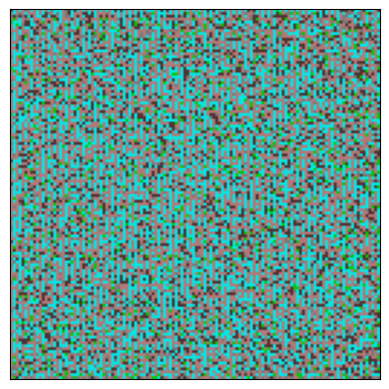

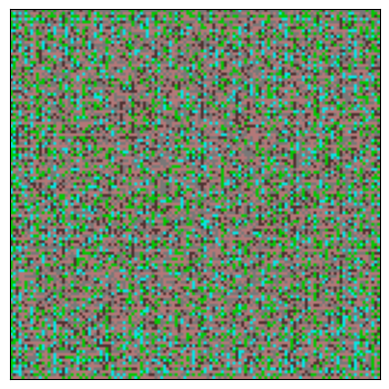

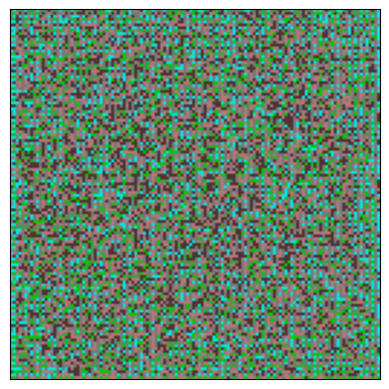

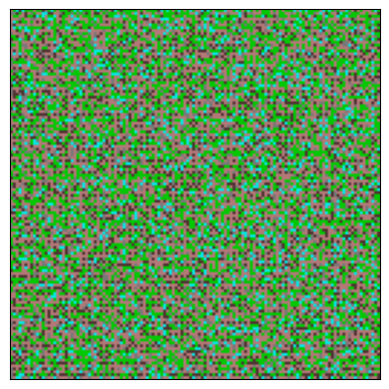

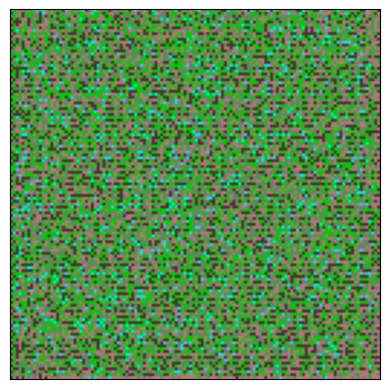

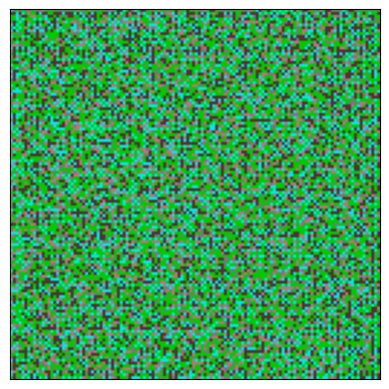

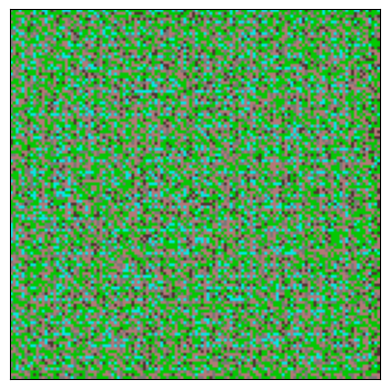

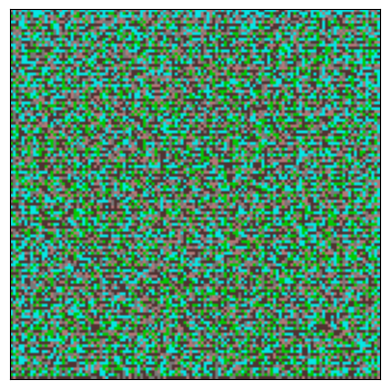

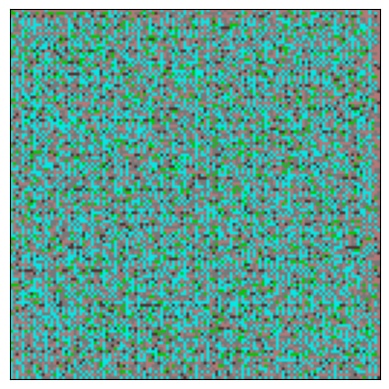

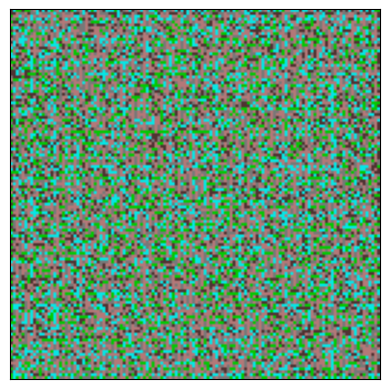

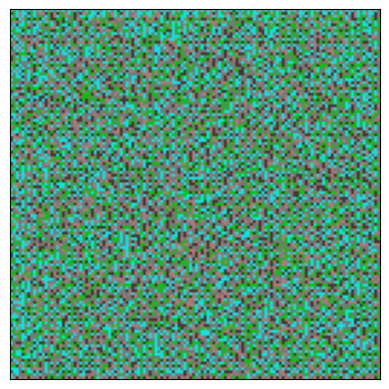

In [41]:
from semseg.datasets import *

#model = model.to(device)
predictions = []
start = time.time()
#print('test')
# Use torch.no_grad() to disable gradient computation during testing
with torch.no_grad():

    for images, labels in train_loader:
        # Move the data to the desired device
        #print(images.shape)
        #images = images.permute(0,3,1,2).to(device)
        #images = images.permute(2,0,1).to(device)
        #images = images [None, :, :, :]
        #print(images.shape)

        #print(images.shape)
        #labels = labels.to(device)

        # Forward pass to get the predictions
        with torch.inference_mode():
          prediction = model(images.to(device))
        #print(prediction)
        prediction = prediction.softmax(1).argmax(1).to(int)
        #prediction = prediction.round().to(int)
        #print(prediction.shape)
        un = prediction.unique()
        #print(un)
        palette = eval('ADE20K').PALETTE.to(device)
        prediction_map = palette[prediction].squeeze().to(torch.uint8)
        #print(type(prediction_map))
        show_image(prediction_map)
        predictions.append(prediction_map)

end = time.time()
print(end-start)